In [1]:
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
summed_sen_df = pickle.load( open( "sen_dataframes/sen_data_summed.p", "rb" ) )  
not_summed_sen_df = pickle.load( open( "sen_dataframes/sen_data.p", "rb" ) )  

In [3]:
#drops the 50 cases with the greatest error
summed_sen_df.drop(error_names, inplace = True)

NameError: name 'error_names' is not defined

In [4]:
from sklearn.model_selection import train_test_split 
def generate_training_data(dataframe, predicting):
    '''
    If you want to retrain algorithm with diffrent hyperparameters of train a new model altogether,
    this function will take the dataframe and return vectors which are used to train and evaluate the models.

    X_all and y_all should only be used to train a regressor that 
    will make a prediction on a case outside of the Whisper catalogue.

    Parameters
    ----------
        dataframe : Pandas DataFrame
        Should contain all of the cases that will be trained and tested upon.

        predicting : string
        Either 'bias' or 'keig_meas' depending on what you're predicting
    Returns
    -----------
    X_train, X_test, X_all, matrix of shape = [n_samples, n_features]
    y_train, y_test, y_all, array, shape = [n_samples, 1]
    '''
    train_set, test_set = train_test_split(dataframe, test_size=0.2, random_state=42)

    X_all = np.vstack(dataframe['s'].values)
#    X_all = np.insert(X_all, 0, dataframe['keig_siml'], axis =1)

    y_all = np.asarray(dataframe[predicting].values).reshape(-1,1)

    X_train = np.vstack(train_set['s'].values)
    X_test = np.vstack(test_set['s'].values)

#    X_train = np.insert(X_train, 0, train_set['keig_siml'], axis =1)
#    X_test = np.insert(X_test, 0, test_set['keig_siml'], axis =1)

    y_train = np.asarray(train_set[predicting].values).reshape(-1,1)
    y_test = np.asarray(test_set[predicting].values).reshape(-1,1)
    
    return X_train, X_test, y_train, y_test, X_all, y_all

X_train, X_test, y_train, y_test, X_all, y_all = generate_training_data(summed_sen_df, 'bias')

In [5]:
from sklearn import preprocessing
def norm_data_for_nn():
    '''The data fed to a neural network must be normalized unlike the decision trees.
       Centers the data with a mean of 0 and a standard deviation of 1.
    '''
    scaler = preprocessing.StandardScaler()
    X_train_nn = scaler.fit_transform(X_train)
    X_test_nn = scaler.fit_transform(X_test)

    y_train_nn = scaler.fit_transform(y_train)
    y_test_nn = scaler.fit_transform(y_test)

    X_all_nn = scaler.fit_transform(X_all)
    y_all_nn = scaler.fit_transform(y_all)

    return X_train_nn, X_test_nn, y_train_nn, y_test_nn, X_all_nn, y_all_nn

X_train_nn, X_test_nn, y_train_nn, y_test_nn, X_all_nn, y_all_nn = norm_data_for_nn()

C:\Users\grech\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [6]:
from sklearn.feature_selection import RFECV
selector = pickle.load( open( "sen_dataframes/feature_selector.p", "rb" ) )
sen_data = np.vstack(summed_sen_df['s'].values)
imp_sen = selector.transform(sen_data)
X_all_important = np.insert(imp_sen, 0, summed_sen_df['keig_siml'], axis =1)

In [7]:
from sklearn.model_selection import cross_val_score
def cross_val(classifier, X_train, y_train):
    scores = cross_val_score(classifier, X_train, y_train.ravel(),
                         scoring="neg_mean_squared_error", cv=10)
    print("MSE Values:", scores)
    print("Mean MSE:", scores.mean())
    print("Standard deviation of MSE:", scores.std())
    print('Mean RMSE:', np.sqrt(abs(scores.mean())))

In [8]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)    
    print('mse {}, rmse {}'.format(mse, rmse))
    print('Coefficient of Determination R^2:', model.score(X_test, y_test))
    print('Mean Absolute Error:', mae)

In [9]:
from sklearn.model_selection import cross_val_predict

def generate_predictions(regressor):
    y_predicted = cross_val_predict(regressor, imp_sen, y_all.ravel(), cv=10)
    y_predicted = y_predicted.reshape(-1,1)
    return y_predicted

In [10]:
def generate_statistics(error):
    absolute_errors = abs(error)
    squared_errors = error**2
    summed_errors = squared_errors.sum()
    mse = summed_errors/float(len(error))
    rmse = np.sqrt(mse)
    mae = absolute_errors.sum()/len(error)
    print(mse, rmse, mae)
    return mse, rmse, mae

In [11]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(max_features=200, n_estimators=1000, random_state = 42) 
#forest_reg = RandomForestRegressor(max_features='auto', n_estimators=1000, random_state = 42) 
forest_reg.fit(X_train, y_train.ravel())
#forest_reg.fit(X_all, y_all.ravel())

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=200, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [12]:
evaluate_model(forest_reg, X_test, y_test)
forest_reg.feature_importances_[0]

mse 9.633287272675328e-06, rmse 0.0031037537390513647
Coefficient of Determination R^2: 0.7924446634
Mean Absolute Error: 0.00205896568807


0.0071851744097349169

In [13]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

ADA = AdaBoostRegressor(DecisionTreeRegressor(max_depth = 35, max_features=300, splitter ='best', max_leaf_nodes=80),
 n_estimators=1000, learning_rate=1.3)
ADA.fit(X_train, y_train.ravel())
#ADA.fit(X_all, y_all.ravel())

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=35, max_features=300,
           max_leaf_nodes=80, min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         learning_rate=1.3, loss='linear', n_estimators=1000,
         random_state=None)

In [14]:
evaluate_model(ADA, X_test, y_test)
ADA.feature_importances_[0]

mse 8.211585137656888e-06, rmse 0.002865586351457043
Coefficient of Determination R^2: 0.823076145346
Mean Absolute Error: 0.00201400009497


0.0054602280368920503

In [15]:
from sklearn.ensemble import ExtraTreesRegressor

ETR = ExtraTreesRegressor(n_estimators = 1000, max_features=100, bootstrap = True)
ETR.fit(X_train, y_train.ravel())
#ETR.fit(X_all, y_all.ravel())

ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=None,
          max_features=100, max_leaf_nodes=None, min_impurity_split=1e-07,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
          oob_score=False, random_state=None, verbose=0, warm_start=False)

In [16]:
evaluate_model(ETR, X_test, y_test)
ETR.feature_importances_[0]

mse 9.418023028954342e-06, rmse 0.0030688797677579913
Coefficient of Determination R^2: 0.797082669233
Mean Absolute Error: 0.00198689005201


0.0072149017390032424

In [17]:
y_forest = generate_predictions(forest_reg) 

In [18]:
y_ETR = generate_predictions(ETR) 

In [19]:
y_ADA = generate_predictions(ADA) 

In [20]:
forest_err = y_forest - y_all
ETR_err =y_ETR - y_all
ADA_err = y_ADA - y_all
errors = [forest_err, ETR_err, ADA_err]

In [21]:
for i in errors:
    generate_statistics(i)

2.8521021957230613e-05 0.00534050764977 0.0037316261879649718
3.2705202448280734e-05 0.0057188462515 0.003933639664939887
2.979325529774261e-05 0.0054583198237 0.0038410441628802167


In [22]:
def generate_sorted_error(regressor_error):
    rel_errors = tuple(zip(summed_sen_df.index, regressor_error))
    rel_errors_sorted = sorted(rel_errors, reverse = True, key = lambda v:v[1])  
    return rel_errors_sorted

In [23]:
for_sorted = generate_sorted_error(forest_err)
ETR_sorted = generate_sorted_error(ETR_err)
ADA_sorted = generate_sorted_error(ADA_err)

In [24]:
def gen_sorted_name_error(sorted_err_tuple):
    sorted_err_names = []
    sorted_errors = []
    for i in range(len(sorted_err_tuple)):
        sorted_err_names.append(sorted_err_tuple[i][0])
        sorted_errors.append(sorted_err_tuple[i][1])
    return sorted_err_names, sorted_errors

In [25]:
forest_names_sorted, forest_err_sorted = gen_sorted_name_error(for_sorted)
ETR_names_sorted, ETR_err_sorted = gen_sorted_name_error(ETR_sorted)
ADA_names_sorted, ADA_err_sorted = gen_sorted_name_error(ADA_sorted)

In [26]:
from collections import Counter

short_names = []
for i in summed_sen_df.index:
    short_names.append(i[:7])
short_data = Counter(short_names).most_common()

In [27]:
labels = ['heu-met',
 'leu-comp',
 'pu-sol',
 'u233-sol',
 'heu-sol',
 'pu-met',
 'pu-comp',
 'mix-met',
 'leu-sol',
 'heu-comp',
 'mix-sol',
 'mix-comp',
 'ieu-met',
 'u233-met',
 'u233-comp',
 'ieu-comp']

In [28]:
def generate_type_errors(reg_err):
    rel_errors = tuple(zip(summed_sen_df.index, reg_err))
    case_errors = []
    for i, type_case in enumerate(short_data):
        case_type = type_case[0]
        errors = []
        for i, case_error in enumerate(rel_errors):
            short_name = case_error[0][:7]
            error = float(case_error[1])

            if short_name == case_type:
                errors.append(error)
        case_errors.append(errors)
        
        case_errors_array = np.array([np.array(x) for x in case_errors])
    return case_errors_array

In [29]:
def gen_type_MSE_MAE_data(reg_err):
    type_mse = []
    type_mae = []
    for i in generate_type_errors(reg_err):
        mse, rmse, mae = generate_statistics(i)
        type_mse.append(mse)
        type_mae.append(mae)    
    
    return type_mse, type_mae

In [30]:
for_MSE, for_MAE = gen_type_MSE_MAE_data(forest_err)
ETR_MSE, ETR_MAE = gen_type_MSE_MAE_data(ETR_err)
ADA_MSE, ADA_MAE = gen_type_MSE_MAE_data(ADA_err)

1.79285105252e-05 0.00423420718969 0.0028643618124
7.57618762818e-06 0.00275248753461 0.00174816909101
2.48373437229e-05 0.00498370782881 0.00397511670264
3.44002972236e-05 0.00586517665749 0.00440688175706
2.32922439893e-05 0.00482620389015 0.00383465775785
4.47250533891e-05 0.00668767922295 0.00572749837332
0.000164496122414 0.0128256041735 0.010202774938
1.047207942e-05 0.00323605924236 0.00271089095216
6.43977495578e-06 0.00253767116778 0.00189759880587
7.22217514546e-05 0.0084983381584 0.00801147592646
0.000105888150611 0.0102901968208 0.007534696753
1.89515857497e-05 0.00435334190591 0.00358078069964
1.75214424475e-05 0.00418586221077 0.00310840713149
7.72632458248e-06 0.0027796266984 0.00262017597452
1.5597012089e-05 0.00394930526663 0.00368823692031
2.188334355e-07 0.000467796361144 0.000467796361144
1.87247875847e-05 0.00432721476064 0.00296680055524
8.55885303709e-06 0.00292555174917 0.00185381534288
2.59893297405e-05 0.00509797310119 0.0039786587315
3.55924149774e-05 0.00596

In [31]:
names = ['heu-met - 267', 'leu-comp - 182', 'pu-sol - 158', 'u233-sol - 139',
 'heu-sol - 93', 'pu-met - 68', 'pu-comp - 36','mix-met - 34', 'leu-sol - 27',
 'heu-comp - 26','mix-sol - 21', 'mix-comp - 18', 'ieu-met - 12', 'u233-met - 10','u233-comp - 9']

def plotError_among_benchType(err_by_type, filename):
    
    x_pos = np.arange(len(err_by_type))
    fig, (ax) = plt.subplots(1, dpi = 160)
    x = ax.get_xaxis()
    x.set_ticks(x_pos)
    x.set_ticklabels([])
    x.set_ticklabels(names,rotation=80)
    ax.bar(x_pos[:-1], err_by_type[:-1])

    ax.set_ylabel('MSE')
    ax.set_title('MSE Among Benchmark Types')
#    plt.savefig('figures/'+ filename +'.jpeg', bbox_inches='tight')
    plt.show()

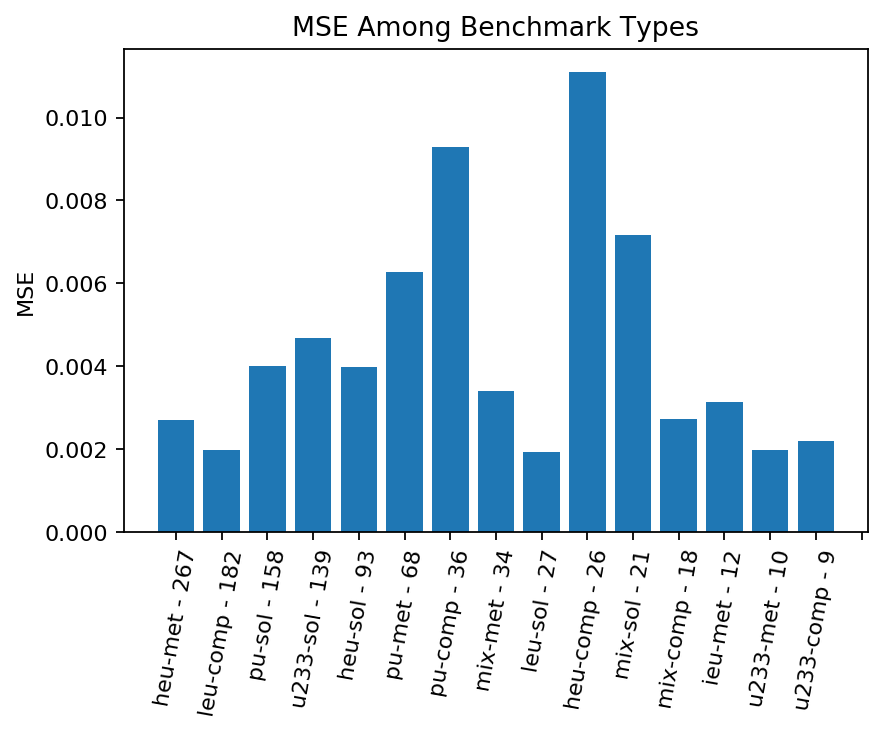

In [32]:
#plotError_among_benchType(for_MAE, 'for_MSE_err')
#plotError_among_benchType(ETR_MAE, 'ETR_MSE_err')
plotError_among_benchType(ADA_MAE, 'ADA_err_predicting_biasMSE')

In [33]:
def gen_error_plot(reg_err, regressor, file_name):
    
    median = np.median(reg_err)
    mean = np.mean(reg_err)

    case_errors_array = generate_type_errors(reg_err)
    
    fig, (ax) = plt.subplots(1, dpi = 160)
    last_point = 0
    for i, case in enumerate(case_errors_array):
        ax.scatter(range(last_point, last_point + len(case)), case, label = labels[i])
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        last_point = last_point +len(case)

    xs = np.linspace(1,1100,100)
    median_data = np.array([median for i in range(len(xs))])
    mean_data = np.array([mean for i in range(len(xs))])

#    ax.plot(xs, median_data, 'r--') 
#    ax.plot(xs, mean_data, 'b-') 

    ax.set_ylabel('Error (Prediced - Actual $k_{eff}$)')
    ax.set_title('Errors of '+ regressor +' on Predicting $k_{eff}$')
    ax.set_ylim([-0.02, 0.02])
    #ax.set_ylim([.99, 1.015])
#    plt.savefig('figures/'+ file_name +'.jpeg', bbox_inches='tight')
    plt.show()

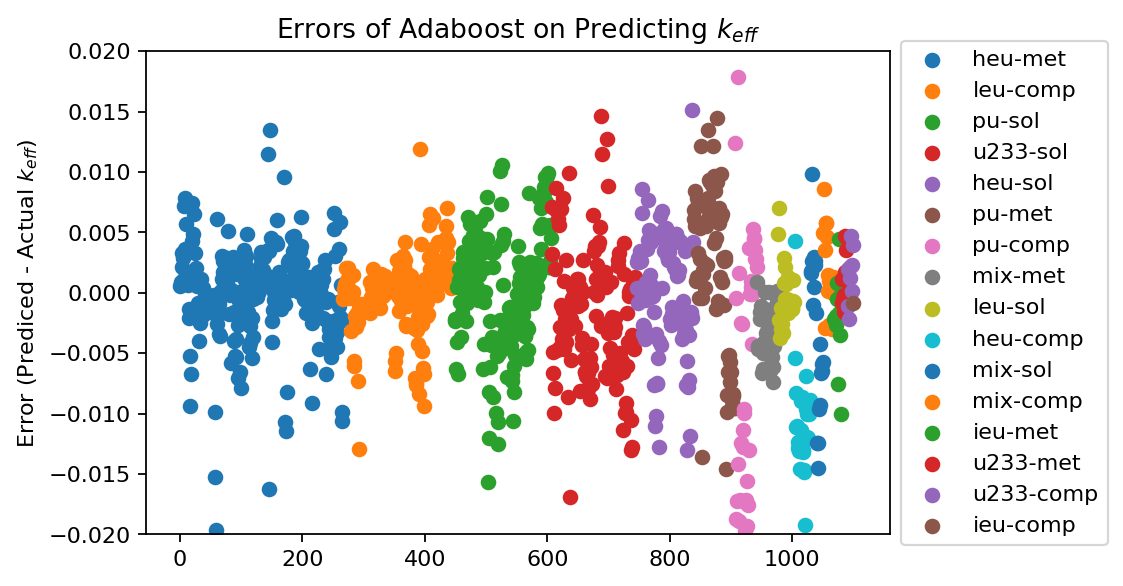

In [34]:
#gen_error_plot(forest_err, 'Random Forest', 'rand_for_err')
#gen_error_plot(ETR_err, 'Extra Trees', 'ETR_err')
gen_error_plot(ADA_err, 'Adaboost', 'ADA_err_predicting_bias')

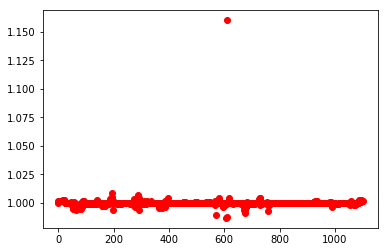

In [35]:
plt.plot(summed_sen_df.keig_meas.values, 'ro')
plt.show()

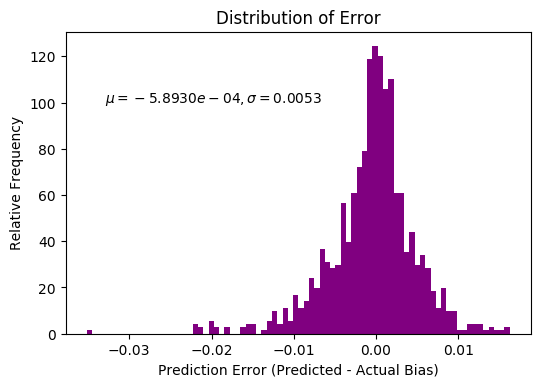

In [36]:
from matplotlib.pyplot import mlab
def plot_MSE_hist(error, clf, name): #
    fig, (ax2) = plt.subplots(1, dpi = 100)#

    #ax2.hist(squared_error, normed = True, bins = 20, color = 'r')
    ax2.set_title('Distribution of Error')
    ax2.set_xlabel('Prediction Error (Predicted - Actual Bias)')
    ax2.set_ylabel('Relative Frequency')

    n, bins, patches = plt.hist(error, 80, normed=1, color = '#800080')
    mu = np.mean(error)
    sigma = np.std(error)
    ax2.text(-.033, 100, '$\mu = {:.4e}, \sigma = {:.4f}$'.format(mu, sigma))
#    ax2.plot(bins, mlab.normpdf(bins, mu, sigma))



#    plt.savefig('figures/'+ name +'.jpeg', bbox_inches='tight')
    plt.show()

plot_MSE_hist(forest_err, 'Neural Netowrks', 'ADA_only_sen_error_profile')

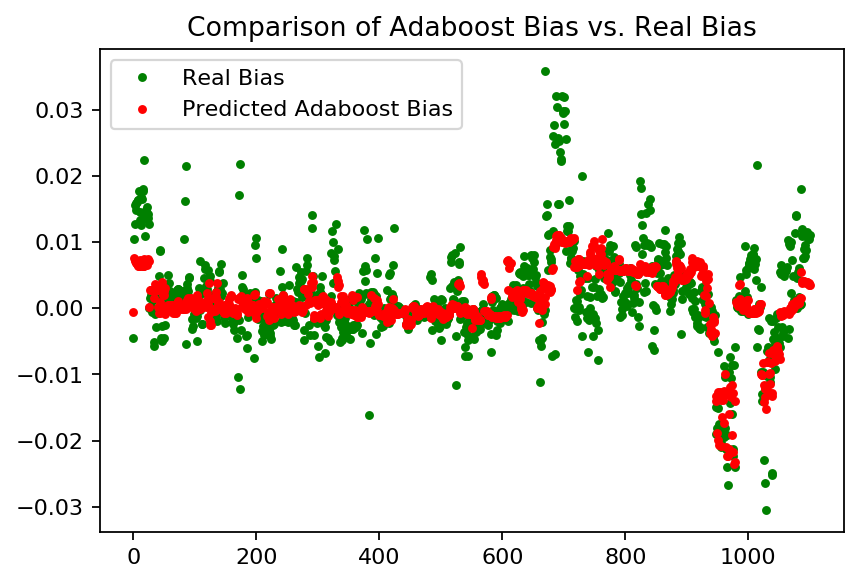

In [37]:
import matplotlib.pyplot as plt
fig, (ax) = plt.subplots(1, dpi = 160)


ax.plot(y_all, 'g.', label = 'Real Bias') 
 
ax.plot(y_forest, 'r.', label = 'Predicted Adaboost Bias')
ax.set_title('Comparison of Adaboost Bias vs. Real Bias')
ax.legend()
#plt.savefig('figures/Adaboost_predictions_wOut_Ksim.jpeg', bbox_inches='tight')
plt.show()

In [38]:
top150_error_names = ADA_names_sorted[:50] + forest_names_sorted[:50] + ETR_names_sorted[:50]
top50_error_names = Counter(top150_error_names).most_common()[:50]
error_names = top150_error_names[:50]

In [39]:
total_sen = abs(summed_sen_df.loc['leu-comp-therm-079-010'].s).sum()
total_sen

2.279643941060808

In [40]:
leu_comp = summed_sen_df.loc['leu-comp-therm-079-010'].s

In [41]:
iso_rxn = pd.read_csv("sen_dataframes/all_isotope_reactions.csv", index_col = 0) 

In [42]:
iso_rxn_imp = list(zip(iso_rxn.index, leu_comp))

In [43]:
iso_rxn_imp[180:200]

[('92238.80c elastic', 0.010401976510000001),
 ('92238.80c inelastic', 0.01571734701),
 ('92238.80c fission', 0.024418753011769996),
 ('92238.80c n2n', 0.00086122130000000001),
 ('92238.80c ngamma', -0.10716078423999999),
 ('92238.80c np', 0.0),
 ('92238.80c nd', 0.0),
 ('92238.80c nt', 0.0),
 ('92238.80c n3he', 0.0),
 ('92238.80c nalpha', 0.0),
 ('92238.80c total nu', 0.035418077530139994),
 ('92238.80c fission chi', 3.5184000000100459e-08),
 ('16032.80c elastic', 0.0),
 ('16032.80c inelastic', 0.0),
 ('16032.80c fission', 0.0),
 ('16032.80c n2n', 0.0),
 ('16032.80c ngamma', 0.0),
 ('16032.80c np', 0.0),
 ('16032.80c nd', 0.0),
 ('16032.80c nt', 0.0)]

In [44]:
U234 = leu_comp[144:156]
abs(U234).sum()

0.00098399309524709998

In [45]:
U235 = leu_comp[156:168]
abs(U235).sum()

1.4193322620237292

In [46]:
U238 = leu_comp[180:192]
abs(U238).sum()

0.19397819478590994

In [47]:
0.00098399309524709998/2.279643941060808*100

0.0431643327066774